In [1]:
import pennylane as qml
import qiskit
from jax import numpy as jnp
import numpy as np
import jax

In [2]:
import sys
sys.path.append('../../')

In [3]:
from pqcqec.circuits.generate import generate_random_circuit

In [4]:
NUM_QUBITS = 3
NUM_GATES = 2
PQC_BLOCKS = 1
GATE_BLOCKS = 1
SEED = 5

In [5]:
qiskit_random_circuit = generate_random_circuit(
    num_qubits=NUM_QUBITS,
    num_gates=NUM_GATES,
    seed=SEED)

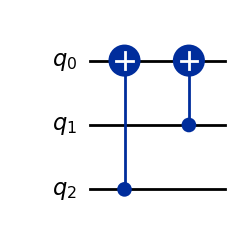

In [6]:
qiskit_random_circuit.draw(output='mpl')  # Display the circuit using Qiskit's drawing capabilities

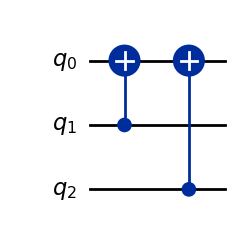

In [7]:
qiskit_random_circuit_inv = qiskit_random_circuit.inverse()
qiskit_random_circuit_inv.draw(output='mpl')  # Display the inverse circuit

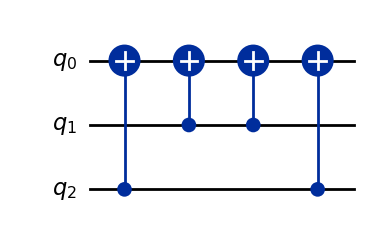

In [8]:
qiskit_uncomp_circuit = qiskit_random_circuit.compose(qiskit_random_circuit_inv, inplace=False)
qiskit_uncomp_circuit.draw(output='mpl')  # Display the uncomputed circuit

In [9]:
circ_op_list = []
for ins in qiskit_uncomp_circuit.data:
    circ_op_list.append((ins.operation.name, [q._index for q in ins.qubits]))
    
print("Circuit Operations:")
for op, qubits in circ_op_list:
    print(f"Gate: {op}, Qubits: {qubits}")  

Circuit Operations:
Gate: cx, Qubits: [2, 0]
Gate: cx, Qubits: [1, 0]
Gate: cx, Qubits: [1, 0]
Gate: cx, Qubits: [2, 0]


In [10]:
class PennylaneNoisyGates:
    def __init__(
        self,
        x_rad: float = jnp.pi / 30,
        z_rad: float = jnp.pi / 30,
        delta_x: float = 5,
        delta_z: float = 5,
    ):
        # Store the *nominal* over-rotation angles
        self.x_noise = x_rad
        self.z_noise = z_rad

        # Convert the percentage deltas into absolute radian offsets
        self.delta_x = delta_x * self.x_noise / 100.0
        self.delta_z = delta_z * self.z_noise / 100.0

        self.x_noise_max = x_rad + self.delta_x
        self.x_noise_min = x_rad - self.delta_x
        self.z_noise_max = z_rad + self.delta_z
        self.z_noise_min = z_rad - self.delta_z

        self.noisy_gates = {
            "X": self.noisyX, "PauliX": self.noisyX, "x": self.noisyX,
            "Z": self.noisyZ, "PauliZ": self.noisyZ, "z": self.noisyZ,
            "CX": self.noisyCX, "CNOT": self.noisyCX, "cx": self.noisyCX, "cnot": self.noisyCX,
            "CZ": self.noisyCZ, "cz": self.noisyCZ,
            "H": self.noisyH, "Hadamard": self.noisyH, "h": self.noisyH
        }

        self.X = self.noisyX
        self.PauliX = self.noisyX
        self.Z = self.noisyZ
        self.PauliZ = self.noisyZ
        self.CX = self.noisyCX
        self.CNOT = self.noisyCX
        self.CZ = self.noisyCZ
        self.H = self.noisyH
        self.Hadamard = self.noisyH

    def apply_gate(self, gate_name, wires):
        """Apply the noisy gate based on its name."""
        if gate_name in self.noisy_gates:
            self.noisy_gates[gate_name](wires)
        else:
            raise ValueError(f"Gate {gate_name} is not supported by the noisy gates model.")    

    def apply_noise(self, wires):
        x_noise = np.random.uniform(self.x_noise_min, self.x_noise_max, size=len(wires))
        z_noise = np.random.uniform(self.z_noise_min, self.z_noise_max, size=len(wires))
        for i, wire in enumerate(wires):
            # Apply the noisy X gate with random over-rotation
            qml.RX(x_noise[i], wires=wire, id="x_noise")
            # Apply the noisy Z gate with random over-rotation
            qml.RZ(z_noise[i], wires=wire, id="z_noise")

    def noisyX(self, wires):
        """Noisy X gate with random over-rotation."""
        qml.PauliX(wires=wires)
        self.apply_noise(wires)

    def noisyZ(self, wires):
        """Noisy Z gate with random over-rotation."""
        qml.PauliZ(wires=wires)
        self.apply_noise(wires)

    def noisyCX(self, wires):
        """Noisy CNOT gate with random over-rotation."""
        qml.CNOT(wires=wires)
        self.apply_noise(wires)

    def noisyCZ(self, wires):
        """Noisy CZ gate with random over-rotation."""
        qml.CZ(wires=wires)
        self.apply_noise(wires)

    def noisyH(self, wires):
        """Noisy Hadamard gate with random over-rotation."""
        qml.Hadamard(wires=wires)
        self.apply_noise(wires)


In [11]:
noisy_gates = PennylaneNoisyGates(x_rad=jnp.pi/100, z_rad=jnp.pi/100)

@qml.qnode(qml.device('default.qubit'))
def circuit_drawer(circ_ops):
    for op, qubits in circ_ops:
       noisy_gates.apply_gate(op, qubits)
    
    return qml.state()

pennylane_circ_drawer = qml.draw_mpl(circuit_drawer, decimals=4)

(<Figure size 1500x400 with 1 Axes>, <Axes: >)

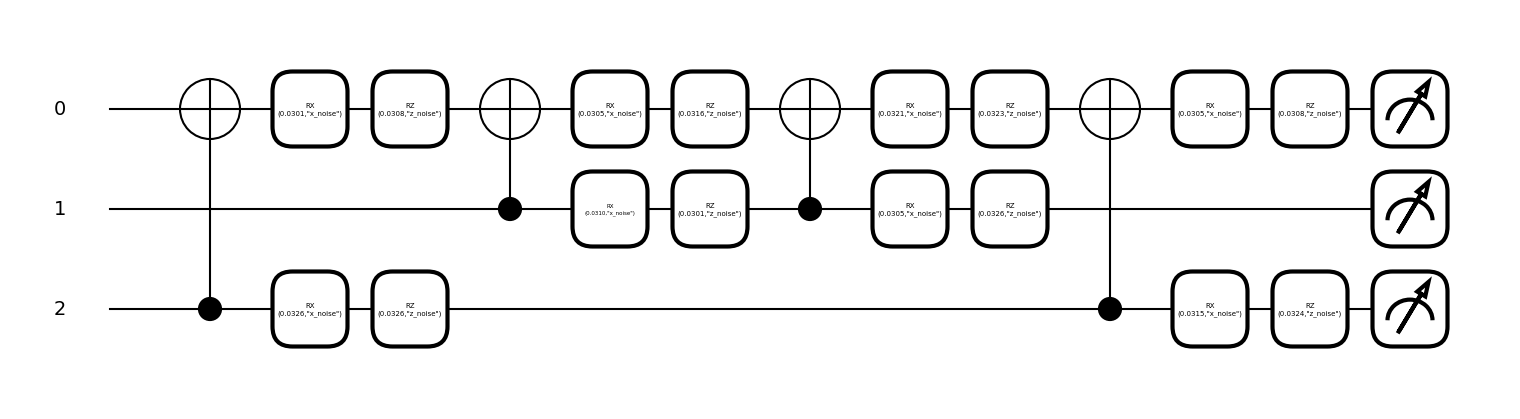

In [12]:
pennylane_circ_drawer(circ_op_list)

In [13]:
from typing import List
import copy

def pennylane_PQC_RZRXRZ_unique(num_qubits:int, params:jnp.ndarray):

    for i in range(num_qubits):
        qml.RZ(params[3*i], i, id='PQC')
        qml.RX(params[3*i + 1], i, id='PQC')
        qml.RZ(params[3*i + 2], i, id='PQC')

def pennylane_state_embedding(input_state, num_qubits):
    """Prepares an arbitrary state as input to the circuit."""
    qml.StatePrep(input_state, wires=range(num_qubits), normalize=True, id='arbitrary_state_prep')


class StateInputNoiseInterleavedPQCModel:
    """A class to define the PQC model."""
    
    def __init__(self, circuit_ops:List, num_qubits, noise_model=PennylaneNoisyGates(),
                 pqc_blocks=1, gate_blocks=1, seed=0):
        """
        Initialize the PQC model with the given parameters.
        Args:
            circuit_ops (List): List of circuit operations to be applied (circuit and its inverse).
            num_qubits (int): Number of qubits in the circuit.
            noise_model (PennylaneNoisyGates): Noise model to be applied.
            pqc_blocks (int): Number of PQC blocks.
            gate_blocks (int): Number of gates per block.
            seed (int): Random seed for parameter initialization.
        """

        self.num_qubits = num_qubits
        self.pqc_arch = pennylane_PQC_RZRXRZ_unique
        self.circuit_ops = copy.deepcopy(circuit_ops)   
        self.num_params = 3 * num_qubits
        self.pqc_blocks = pqc_blocks
        self.gate_blocks = gate_blocks
        self.seed = seed
        self.noise_model = noise_model
        # self.uncomp_circuit = circuit_ops + circuit_ops[::-1]        # self.uncomp_circuit.extend([qml.adjoint(op) for op in self.circuit_ops[::-1]])
        self.num_gates = len(self.circuit_ops)

        self.qdev_cpu = qml.device("default.qubit", wires=self.num_qubits)
        self.diff_method = "backprop"  # Use backpropagation for differentiation

        self.param_sz = (int(self.pqc_blocks * jnp.ceil(self.num_gates/self.gate_blocks)), self.num_params)

        self.pqc_params = jax.random.uniform(jax.random.PRNGKey(self.seed), self.param_sz, jnp.float32, -jnp.pi, jnp.pi)
        # self.pqc_params = pnp.array(init_params, requires_grad=True, dtype=jnp.float32)

        
        @qml.qnode(self.qdev_cpu, interface='jax', diff_method=self.diff_method)
        def model_circuit(state, pqc_params):
            """Define the PQC model circuit."""
            # 1) Apply state embedding:
            pennylane_state_embedding(state, self.num_qubits)

            # @qml.for_loop(0, self.num_gates)
            for i, op in enumerate(self.circuit_ops):
            # def loop_body(i):
                gate, qubit = op
                # Apply the noisy gate:
                noisy_gates.apply_gate(gate, qubit)

                # Apply PQC to the qubit:
                if (i+1) % self.gate_blocks == 0:
                    # 2) Apply the PQC gates:
                    # print(f"Applying PQC block {i // self.gate_blocks + 1} with params: {pqc_params[i // self.gate_blocks]}")
                    pqc_params_block = pqc_params[i // self.gate_blocks]
                    self.pqc_arch(self.num_qubits, pqc_params_block)
            
            # 3) Return the output state:
            return qml.state()
        

        self.model_circuit = model_circuit
        self.batched_model_circuit = jax.jit(jax.vmap(self.model_circuit, in_axes=(0, None)))

    def run_model_batch(self, in_state, params=None):
        """Run the model circuit on the BATCHED parameters and return the output state."""
        if params is None:
            params = self.pqc_params
        return self.batched_model_circuit(in_state, params)

    def __call__(self, *args, **kwds):
        return self.run_model_batch(*args, **kwds)
    
    def __str__(self):
        return str(self.circuit_ops)

    def draw_mpl(self, in_state, params=None):
        """Draw the model circuit using matplotlib."""
 
        if params is None:
            params = self.pqc_params

        print(f"Drawing circuit with params: {params}")
        print(f"Input state: {in_state}")
        print(f'Model: {self}')

        return qml.draw_mpl(self.model_circuit, decimals=4)(in_state, params)


Drawing circuit with params: [[-0.21124144  2.6444736   1.481639   -2.5441782   2.6043153   1.1167059
  -3.0357742  -2.8013523  -1.8772825 ]
 [-0.42019165 -3.1367242  -0.70980996  1.1473203  -0.34382144  2.1549435
  -2.637149   -1.9597901   2.0675104 ]
 [ 1.0610691  -2.7812526   3.0863657  -1.3285906  -0.22653931 -1.5203892
   0.34821066 -1.2579961   2.8010025 ]
 [-2.0025866  -2.5987875  -2.957807   -1.0700849  -1.9320638  -2.5886257
  -0.7374972  -1.4551351  -2.3292248 ]]
Input state: [0. 0. 0. 0. 0. 0. 0. 0.]
Model: [('cx', [2, 0]), ('cx', [1, 0]), ('cx', [1, 0]), ('cx', [2, 0])]


(<Figure size 2800x400 with 1 Axes>, <Axes: >)

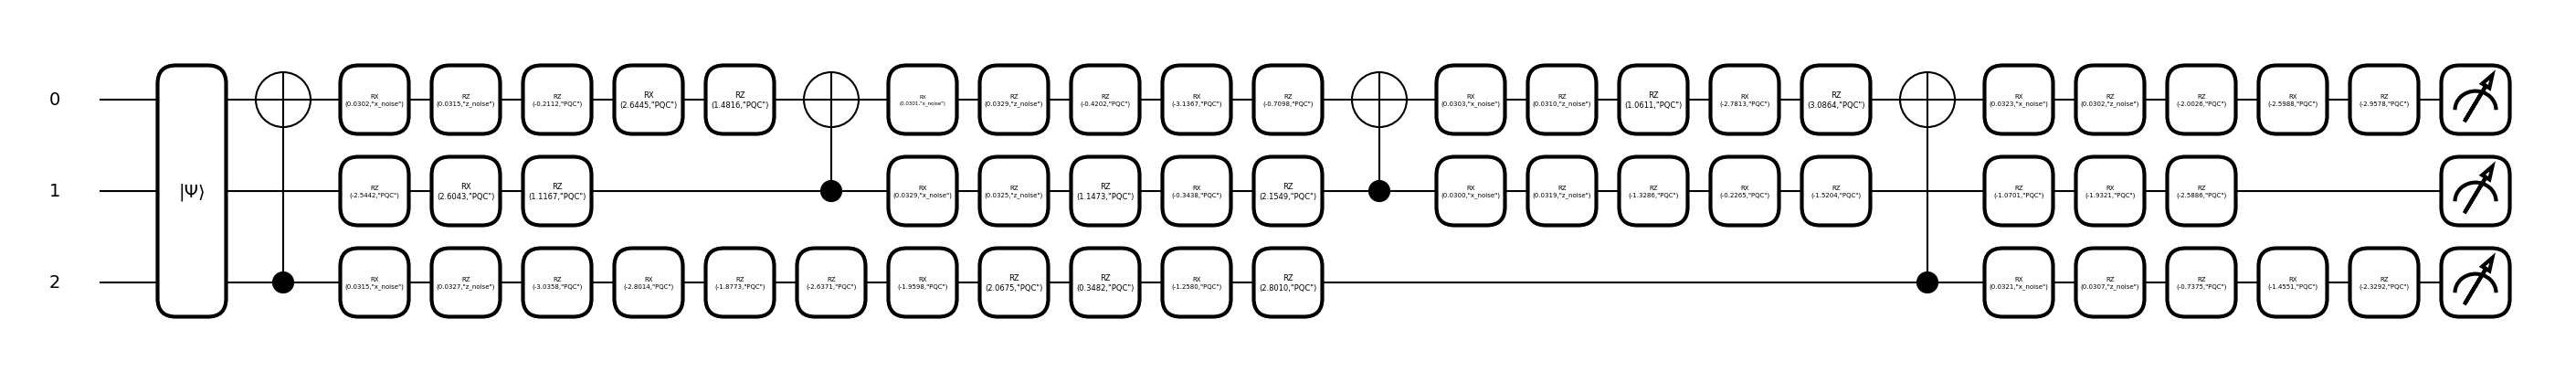

In [14]:
model = StateInputNoiseInterleavedPQCModel(circ_op_list, 
                                           NUM_QUBITS, 
                                           noise_model=noisy_gates, 
                                           pqc_blocks=PQC_BLOCKS, 
                                           gate_blocks=GATE_BLOCKS, 
                                           seed=SEED)

model.draw_mpl(jnp.zeros(2**NUM_QUBITS))